In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt
from IPython.display import Image

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
from DiffNet.datasets.parametric.images import ImageIMBack

from e1_complex_immersed_background import Poisson

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [8]:
def plot_contours_query(dirpath,nu,f,u):
    # plotting
    num_query = nu.shape[0]
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[idx,:,:]
        up = u[idx,:,:]

        im0 = axs[idx][0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[idx,0])
        im1 = axs[idx][1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[idx,1]) 
    plt.savefig(os.path.join(dirpath, 'query.png'))
    # plt.close('all')
    plt.show()

In [9]:
dirname = '../some-data'
case_dir = './complex_immersed_background/version_26'
query_out_path = os.path.join(case_dir, 'query')
if not os.path.exists(query_out_path):
    os.makedirs(query_out_path)
dataset = ImageIMBack(dirname, domain_size=256)
#network = GoodNetwork(in_channels=2, out_channels=1, in_dim=64, out_dim=64)
network = torch.load(os.path.join(case_dir, 'network.pt'))
basecase = Poisson(network, dataset, batch_size=16, domain_size=256)

inputs, forcing = basecase.dataset[0:10]
nu, f, u = basecase.do_query(inputs, forcing)

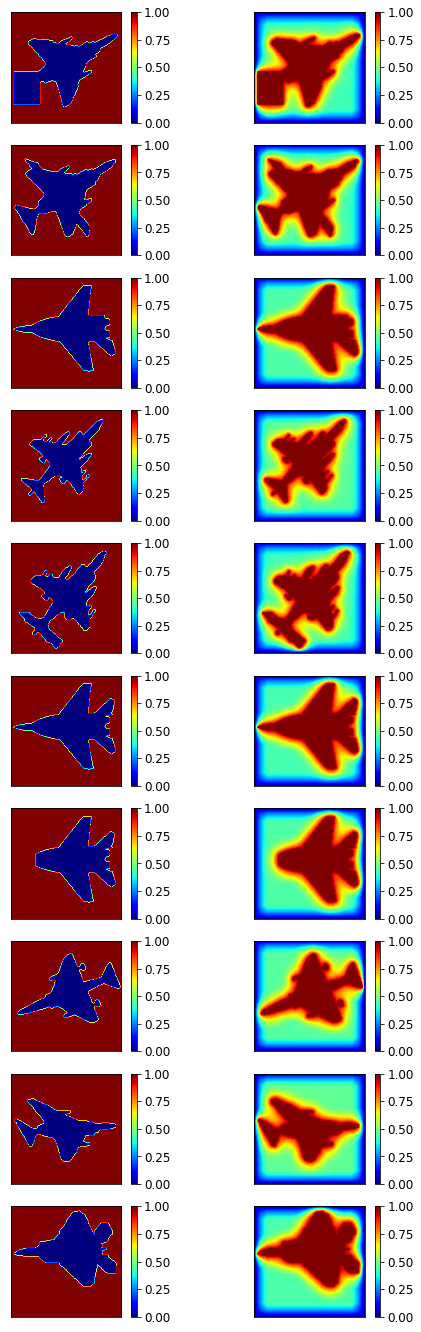

In [10]:
plot_contours_query(query_out_path, nu, f, u)

In [11]:
# Image(filename=os.path.join(query_out_path,'query.png')) 